# Brain Tissue Segmentation

Segmentation of different tissues from MRI scans of the brain is an important step for further downstream applications such as disease prediction, classification or brain age estimation.

Our goal is to implement deep learning approaches for segmentation of different tissue types in MRI scans of the brain, i.e., background, cerebrospinal fluid (CSF), white matter (WM), and gray matter (GM). We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final segmentation accuracy.

Unfortunately I cannot provide the Dataset on which these models are trained.


## Imports

In [3]:
import os
import glob
import random
from argparse import Namespace
from functools import partial
from multiprocessing import Pool
from numbers import Number
from typing import Any, Dict
from typing import List, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchsummary import summary

def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False


def mean_absolute_error(preds: Tensor, targets: Tensor) -> float:
    """Compute the mean absolute error between predictions and targets"""
    return (preds.view(-1) - targets.view(-1)).abs().mean().item()


class TensorboardLogger(SummaryWriter):
    def __init__(
        self,
        log_dir: str = None,
        config: Namespace = None,
        enabled: bool = True,
        comment: str = '',
        purge_step: int = None,
        max_queue: int = 10,
        flush_secs: int = 120,
        filename_suffix: str = ''
    ):
        self.enabled = enabled
        if self.enabled:
            super().__init__(
                log_dir=log_dir,
                comment=comment,
                purge_step=purge_step,
                max_queue=max_queue,
                flush_secs=flush_secs,
                filename_suffix=filename_suffix
            )
        else:
            return

        # Add config
        if config is not None:
            self.add_hparams(
                {k: v for k, v in vars(config).items() if isinstance(
                    v, (int, float, str, bool, torch.Tensor))},
                {}
            )

    def log(self, data: Dict[str, Any], step: int) -> None:
        """Log each entry in data as its corresponding data type"""
        if self.enabled:
            for k, v in data.items():
                # Scalars
                if isinstance(v, Number):
                    self.add_scalar(k, v, step)

                # Images
                elif (isinstance(v, np.ndarray) or isinstance(v, torch.Tensor)) and len(v.shape) >= 3:
                    if len(v.shape) == 3:
                        self.add_image(k, v, step)
                    elif len(v.shape) == 4:
                        self.add_images(k, v, step)
                    else:
                        raise ValueError(f'Unsupported image shape: {v.shape}')

                # Matplotlib figures
                elif isinstance(v, plt.Figure):
                    self.add_figure(k, v, step)

                else:
                    raise ValueError(f'Unsupported data type: {type(v)}')


def load_nii(path: str, dtype: str = 'float32') -> np.ndarray:
    """Load an MRI scan from disk and convert it to a given datatype

    :param path: Path to file
    :param dtype: Target dtype
    :return img: Loaded image. Shape (H, W, D)
    """
    return nib.load(path).get_fdata().astype(np.dtype(dtype))


def load_segmentations(paths: str):
    """Load all segmentations and associated subject_ids"""
    filenames, segmentations = [], []
    for im in tqdm(paths):
        id = im.split('_brain_')[0].split('/')[-1].split('-')[1].split('_')[0]
        segmentations.append(load_nii(im))
        filenames.append(id)
    return filenames, np.array(segmentations)


def plot_segmentations(im: np.ndarray, seg: np.ndarray, i: int = 65, title: str = None):
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))

    col = 2
    ax[0, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[..., i], k=3),
                 alpha=0.5 * (np.rot90(seg[..., i] > 0, k=3)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].set_title('Axial')

    k = 1
    col = 0
    ax[0, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[i, ...], k=k),
                 alpha=0.5 * (np.rot90(seg[i, ...] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].set_title('Sagittal')

    col = 1
    ax[0, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[:, i, :], k=k),
                 alpha=0.5 * (np.rot90(seg[:, i, :] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].set_title('Coronal')

    if title is not None:
        # plt.set_title(title)
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()


writer = SummaryWriter('runs/unet3d_experiment_1')
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

## Imaging data
Let's check out the imaging data that is available for each subject.

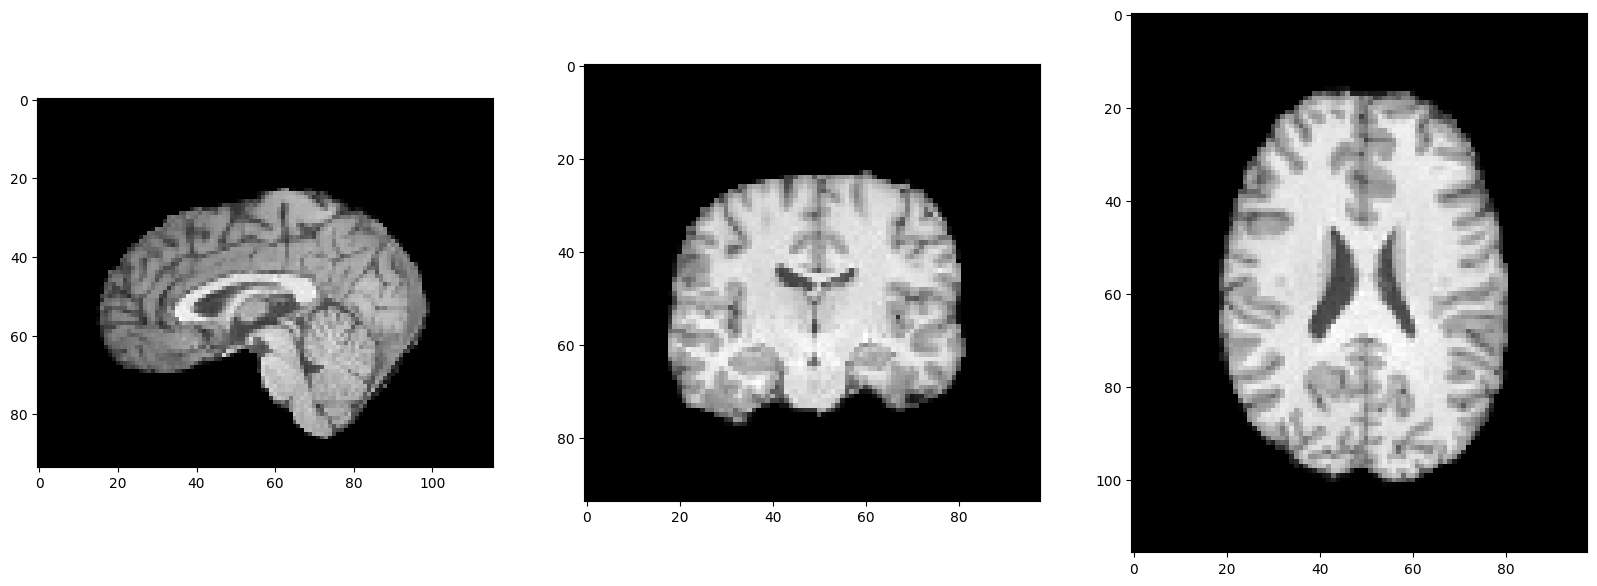

In [4]:
file = './data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz'

image = nib.load(file).get_fdata()

f, axarr = plt.subplots(1, 3, figsize=(20, 10))
H, W, D = image.shape
axarr[0].imshow(np.flip(image[H // 2, :, :].T, axis=0), cmap='gray')
axarr[1].imshow(np.flip(image[:, W // 2, :].T, axis=0), cmap='gray')
axarr[2].imshow(image[:, :, D // 2].T, cmap='gray')
plt.show()

## Data loading and visualization

Let's first load all the data and make a tranin/val/test split

In [5]:
paths = sorted(glob.glob('data/brain_age/segs_refs/*'))
filenames, segmentations = load_segmentations(paths)

100%|██████████| 652/652 [00:15<00:00, 42.71it/s]


In [6]:
np.random.seed(10282022)

all_keys = np.asarray(range(len(filenames)))
ratio_test = int(0.1 * len(all_keys))  # 10% val; 10% test
val_keys = np.random.choice(all_keys, 2 * ratio_test, replace=False)
test_keys = np.random.choice(val_keys, ratio_test, replace=False)

train_files, val_files, test_files = [], [], []
segmentations_train, segmentations_val, segmentations_test =  [],  [], []
for scan_id in tqdm(all_keys):
  scan = f'data/brain_age/images/sub-{filenames[scan_id]}_T1w_unbiased.nii.gz'
  seg = segmentations[scan_id]
  if scan_id in test_keys:
      test_files.append(scan)
      segmentations_test.append(seg)
  elif scan_id in val_keys:
      val_files.append(scan)
      segmentations_val.append(seg)
  else:
      train_files.append(scan)
      segmentations_train.append(seg)
print(f'{len(train_files)} train files')
print(f'{len(val_files)} val files')
print(f'{len(test_files)} test files')

100%|██████████| 652/652 [00:00<00:00, 108670.22it/s]

522 train files
65 val files
65 test files


Let's visualize one validations sample

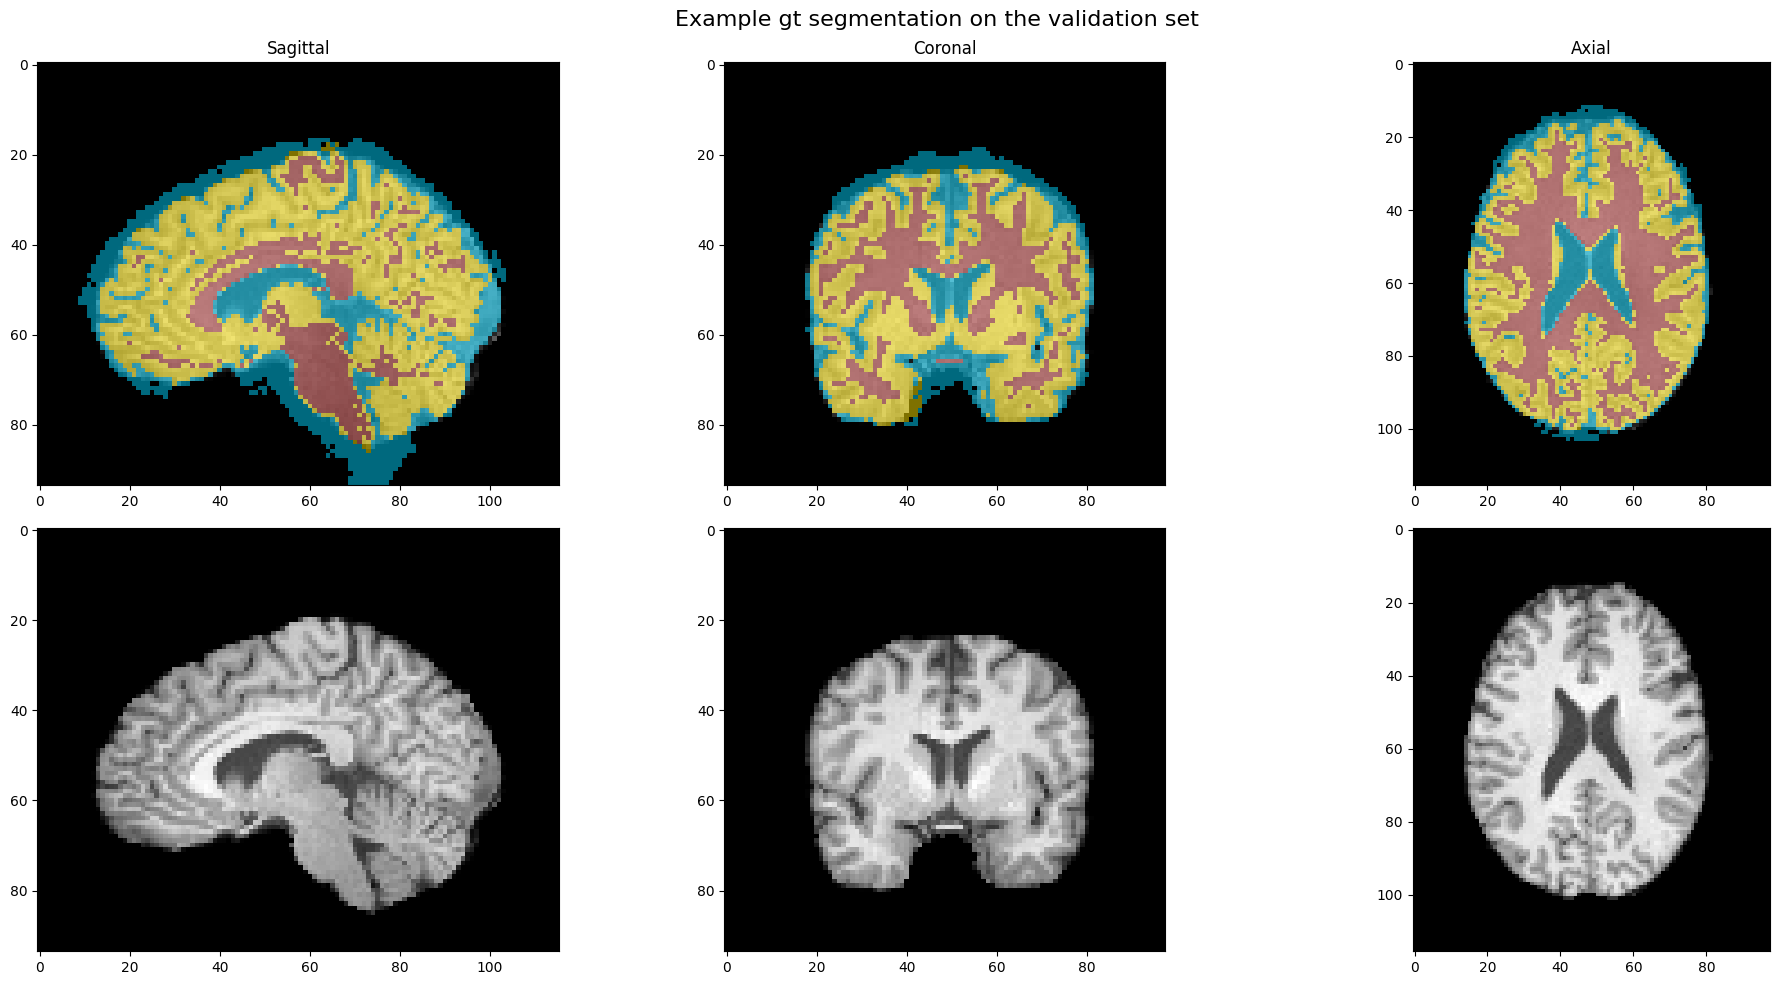

In [7]:
im = load_nii(val_files[0])
plot_segmentations(im, segmentations_val[0], i=47, title='Example gt segmentation on the validation set')

# Evaluation and Visualization

In [31]:
def dice_coefficient(pred, gt, label):
  """Calculate the Dice coefficient for a specific label."""
  pred_bin = (pred == label)
  gt_bin = (gt == label)
  intersection = np.sum(pred_bin & gt_bin)
  return 2.0 * intersection / (np.sum(pred_bin) + np.sum(gt_bin)) if (np.sum(pred_bin) + np.sum(gt_bin)) > 0 else 0

def Dice(predictions, gt):
  """Calculate the mean and standard deviation of the Dice coefficients per image across all labels."""
  labels = [0, 1, 2, 3]  # Assuming labels are 0, 1, 2, 3
  mean_dice = []
  std_dice = []

  # Calculate Dice scores per image, averaged across labels
  for p, g in zip(predictions, gt):
    scores = [dice_coefficient(p, g, label) for label in labels]
    mean_dice.append(np.mean(scores))  # Average score across labels for this image
    std_dice.append(np.std(scores))  # Standard deviation across labels for this image


  return mean_dice, std_dice


def precision(predictions, gt):
  labels = [0, 1, 2, 3]  # Assuming labels are 0, 1, 2, 3
  mean_precision = []
  std_precision = []

  for p, g in zip(predictions, gt):
    label_precisions = []
    for label in labels:
      precision_score = precision_per_label(p, g, label)
      label_precisions.append(precision_score)

    mean_precision.append(np.mean(label_precisions))
    std_precision.append(np.std(label_precisions))

  return mean_precision, std_precision

def precision_per_label(predictions, gt, label):
  """Calculate the precision for a specific label."""
  pred_bin = (predictions == label)
  gt_bin = (gt == label)
  true_positives = np.sum(pred_bin & gt_bin)
  false_positives = np.sum(pred_bin & ~gt_bin)
  return true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

def recall(predictions, gt):
  """Calculate the mean and standard deviation of recall per image across all labels."""
  labels = [0, 1, 2, 3]  # Assuming labels are 0, 1, 2, 3
  recall_scores_per_image = []
  mean_recall = []
  std_recall = []

  for p, g in zip(predictions, gt):
    label_recalls = []
    for label in labels:
      recall_score = recall_per_label(p, g, label)
      label_recalls.append(recall_score)

    mean_recall.append(np.mean(label_recalls))  # Average recall score across labels for this image
    std_recall.append(np.std(label_recalls))  # Standard deviation across labels for this image


  return mean_recall, std_recall

def recall_per_label(predictions, gt, label):
  """Calculate the recall for a specific label."""
  pred_bin = (predictions == label)
  gt_bin = (gt == label)
  true_positives = np.sum(pred_bin & gt_bin)
  false_negatives = np.sum(~pred_bin & gt_bin)
  return true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

# ----------------------------------- END -------------------------------------

**Q1b**. Next, we want to visualize the best- and worst-performing samples in the test set. Implement a function that evaluates the entire test dataset and outputs the index of the best and worst performing samples according to the Dice coefficient.

In [32]:
# You may change the functions below as you see fit

# --------------------------- ADD YOUR CODE HERE ------------------------------
def get_best_and_worst_ids(predictions):
    best_ids, worst_ids = -1, -1
    best_performance, worst_performance = None, None

    # Compute Dice scores for all test samples
    dice_scores, _ = Dice(predictions, segmentations_test)

    # Find best and worst performing samples
    best_ids = np.argmax(dice_scores)
    worst_ids = np.argmin(dice_scores)
    best_performance = dice_scores[best_ids]
    worst_performance = dice_scores[worst_ids]

    return {
        'best_id': best_ids,
        'best_performance': best_performance,
        'worst_id': worst_ids,
        'worst_performance': worst_performance
    }

# ----------------------------------- END -------------------------------------
def visualize_best_and_worst_samples(predictions, i_best=47, i_worst=47):
    return_dict = get_best_and_worst_ids(predictions)
    print(return_dict)

    best_id = return_dict['best_id']
    plot_segmentations(load_nii(test_files[best_id]), predictions[best_id], i=i_best,
                       title=f'Best prediction on the test set (Dice: {return_dict["best_performance"]:.2f})')

    worst_id = return_dict['worst_id']
    plot_segmentations(load_nii(test_files[worst_id]), predictions[worst_id], i=i_worst,
                       title=f'Worst prediction on the test set (Dice: {return_dict["worst_performance"]:.2f})')

# ----------------------------------- END -------------------------------------

**Q1c**. Given a set of predictions for a number of models, create a summary figure of your choice (e.g. table, bar plot) which visualizes all of the metric values. Visualize multiple metrics (Dice coefficient, precision, and recall), each computed for every tissue type. A sample dictionary is provided below.

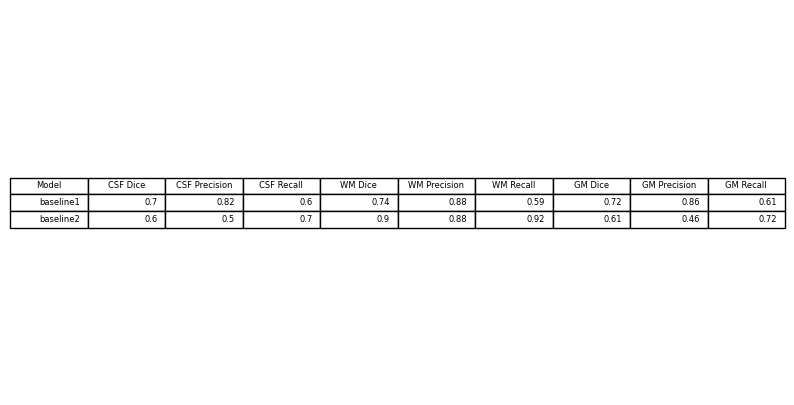

In [33]:
# --------------------------- ADD YOUR CODE HERE ------------------------------
def get_results_dictionary(predictions):
    results_dict = {}
    label_names = ['CSF', 'GM', 'WM']  # Map labels to names

    for label, label_name in zip([1, 2, 3], label_names):
        dice_avg = np.mean([dice_coefficient(p, g, label) for p, g in zip(predictions, segmentations_test)])
        precision_avg = np.mean([precision_per_label(p, g, label) for p, g in zip(predictions, segmentations_test)])
        recall_avg = np.mean([recall_per_label(p, g, label) for p, g in zip(predictions, segmentations_test)])

        results_dict[label_name] = {
            'dice': f'{dice_avg:.2f}',
            'precision': f'{precision_avg:.2f}',
            'recall': f'{recall_avg:.2f}'
        }
    return results_dict

def plot_results_summary(results_dict: Dict[str, Dict[str, Dict[str, str]]]) -> None:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axis('off')
    ax.axis('tight')
    table_data = []
    for model_name, model_results in results_dict.items():
        row = [model_name]
        for tissue_type, tissue_results in model_results.items():
            row.extend([tissue_results['dice'], tissue_results['precision'], tissue_results['recall']])
        table_data.append(row)
    column_labels = ['Model', 'CSF Dice', 'CSF Precision', 'CSF Recall', 'WM Dice', 'WM Precision', 'WM Recall', 'GM Dice', 'GM Precision', 'GM Recall']
    ax.table(cellText=table_data, colLabels=column_labels, loc='center')
    plt.show()
# ----------------------------------- END -------------------------------------

sample_results = {
    'baseline1': {
        'CSF': {'dice': '0.7', 'precision': '0.82', 'recall': '0.6'},
        'GM': {'dice': '0.74', 'precision': '0.88', 'recall': '0.59'},
        'WM': {'dice': '0.72', 'precision': '0.86', 'recall': '0.61'},
    },
    'baseline2': {
        'CSF': {'dice': '0.6', 'precision': '0.5', 'recall': '0.7'},
        'GM': {'dice': '0.9', 'precision': '0.88', 'recall': '0.92'},
        'WM': {'dice': '0.61', 'precision': '0.46', 'recall': '0.72'},
    }
}
plot_results_summary(sample_results)

# Deep supervised segmentation

Deep Learning (DL) methods achieve state-of-the-art results in many (medical) image analyzis applications, including segmentation. Here, you will implement and train a DL method to segment CSF, WM, GM, and background in brain MRI.

First, let's have a look at the individual channels of the segmentations.

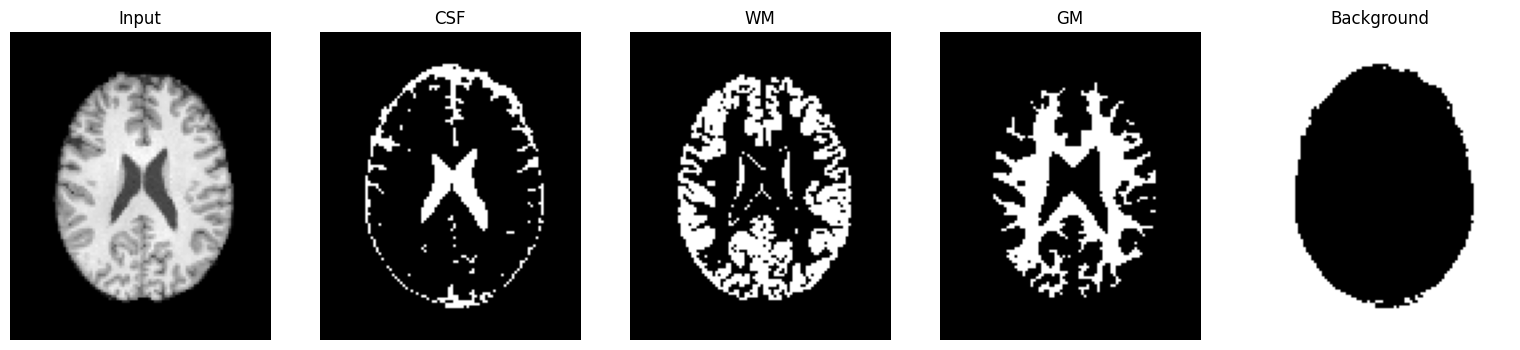

In [20]:
import matplotlib.pyplot as plt
import copy
im = load_nii(val_files[0])
csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[segmentations_val[0]==1] = 1
wm[segmentations_val[0]==2] = 1
gm[segmentations_val[0]==3] = 1
background[segmentations_val[0]==0]=1
elements = [im, csf, wm, gm, background]
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

## DL-based segmentation

In [21]:
class DoubleConv3D(nn.Module):
    """(3D convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet3D(nn.Module):
    def __init__(self, n_channels, n_classes, base_n_filter = 8):
        super(UNet3D, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv3D(n_channels, base_n_filter)
        self.down1 = DoubleConv3D(base_n_filter, base_n_filter*2)
        self.down2 = DoubleConv3D(base_n_filter*2, base_n_filter*4)
        self.down3 = DoubleConv3D(base_n_filter*4, base_n_filter*8)
        self.up1 = DoubleConv3D(base_n_filter*12, base_n_filter*4)
        self.up2 = DoubleConv3D(base_n_filter*6, base_n_filter*2)
        self.up3 = DoubleConv3D(base_n_filter*3, base_n_filter)
        self.outc = nn.Conv3d(base_n_filter, n_classes, kernel_size=1)

    def forward(self, x):
        # Initial padding
        x = F.pad(x, (4, 4, 2, 2, 3, 3))

        # Downscaling path
        x1 = self.inc(x)
        x2 = self.down1(nn.MaxPool3d(2)(x1))
        x3 = self.down2(nn.MaxPool3d(2)(x2))
        x4 = self.down3(nn.MaxPool3d(2)(x3))

        # Upscaling path
        x = self.up1(torch.cat([self.upsample_to_size(x4, x3), x3], 1))
        x = self.up2(torch.cat([self.upsample_to_size(x, x2), x2], 1))
        x = self.up3(torch.cat([self.upsample_to_size(x, x1), x1], 1))


        # Output convolution to get the segmentation map
        logits = self.outc(x)

        # Scale output to original input size
        return F.interpolate(logits, size=[98, 116, 94], mode='trilinear', align_corners=True)
    
    @staticmethod
    def upsample_to_size(upsampled, target):
        return F.interpolate(upsampled, size=target.shape[2:], mode='trilinear', align_corners=True)

    
class MRIImagesDataset(Dataset):
    def __init__(self, images, labels):
        """
        images: NumPy array of your training images, shape (N, depth, height, width)
        labels: NumPy array of your labels, shape (N, depth, height, width)
        """
        self.images = torch.from_numpy(images).float()  # Convert images to PyTorch tensors
        self.labels = torch.from_numpy(labels).long()   # Convert labels to PyTorch tensors

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [22]:
# Define and train a neural network (U-Net) for segmentation
# Implement
# --------------------------- ADD YOUR CODE HERE ------------------------------
val_images = np.asarray([load_nii(f) for f in val_files])
train_dataset = MRIImagesDataset(train_images, np.array(segmentations_train))
val_dataset = MRIImagesDataset(val_images, np.array(segmentations_val))
test_dataset = MRIImagesDataset(test_images, np.array(segmentations_test))


In [23]:

# Hyperparameters
batch_size = 32
num_epochs = 10
lr = 0.001

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [24]:

model = UNet3D(n_channels=1, n_classes=4) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [32, 8, 104, 120, 102]             224
       BatchNorm3d-2     [32, 8, 104, 120, 102]              16
              ReLU-3     [32, 8, 104, 120, 102]               0
            Conv3d-4     [32, 8, 104, 120, 102]           1,736
       BatchNorm3d-5     [32, 8, 104, 120, 102]              16
              ReLU-6     [32, 8, 104, 120, 102]               0
      DoubleConv3D-7     [32, 8, 104, 120, 102]               0
            Conv3d-8       [32, 16, 52, 60, 51]           3,472
       BatchNorm3d-9       [32, 16, 52, 60, 51]              32
             ReLU-10       [32, 16, 52, 60, 51]               0
           Conv3d-11       [32, 16, 52, 60, 51]           6,928
      BatchNorm3d-12       [32, 16, 52, 60, 51]              32
             ReLU-13       [32, 16, 52, 60, 51]               0
     DoubleConv3D-14       [32, 16, 52,

In [25]:
from torch import optim
import os
# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming your model is already defined as UNet3D
model.to(device)  # Move model to the selected device

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Number of epochs
num_epochs = 10  # Adjust as needed

if not os.path.exists('pred_seg_3.pth'):
    # Training and validation loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs = inputs.unsqueeze(1)  # Add a channel dimension
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 10:.4f}')
            writer.add_scalar('Training loss', running_loss / 10, epoch * len(train_loader) + i)
            running_loss = 0.0

        # Validation step
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.unsqueeze(1)  # Add a channel dimension
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
            val_loss = val_running_loss / len(val_loader)
        print(f'Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}')
        writer.add_scalar('Validation loss', val_loss, epoch)

    writer.close()
    print('Finished Training')
    torch.save(model.state_dict(), 'pred_seg_3.pth')
else:
    model.load_state_dict(torch.load('pred_seg_3.pth'))
    print('Loaded model weights from file')

Loaded model weights from file


In [26]:
model.eval()  # Set the model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
test_running_loss = 0.0
all_outputs = []  # List to store all batch outputs

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(1)  # Add a channel dimension
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()

        # Apply argmax to get the most likely class for each voxel
        predicted_classes = torch.argmax(outputs, dim=1)
        all_outputs.append(predicted_classes.cpu())  # Move to CPU and store

# Calculate test loss
test_loss = test_running_loss / len(test_loader)
print(f'test Loss: {test_loss:.4f}')

# Concatenate all outputs to form a single tensor
all_outputs_concatenated = torch.cat(all_outputs, dim=0)

# Convert to numpy array if needed
pred_seg_3 = all_outputs_concatenated.numpy()

# Check the final shape
print(pred_seg_3.shape)

test Loss: 0.3629
(65, 98, 116, 94)


{'best_id': 17, 'best_performance': 0.7967850446562399, 'worst_id': 57, 'worst_performance': 0.7517596509549623}


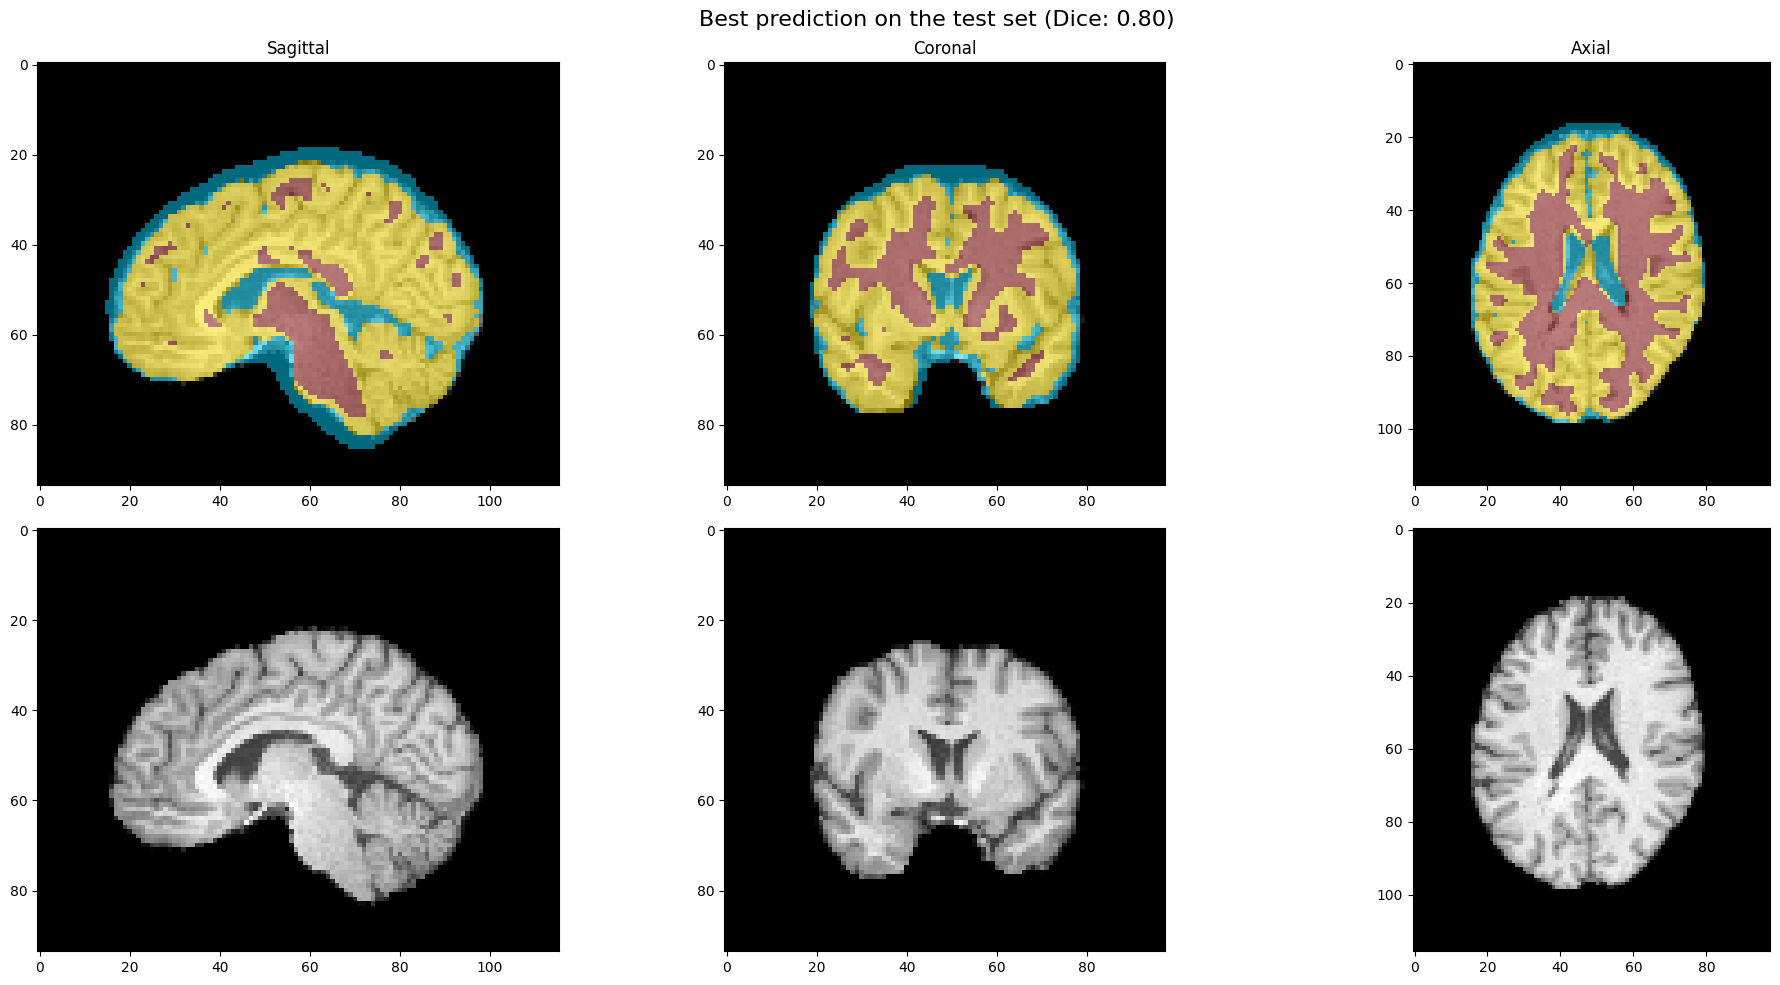

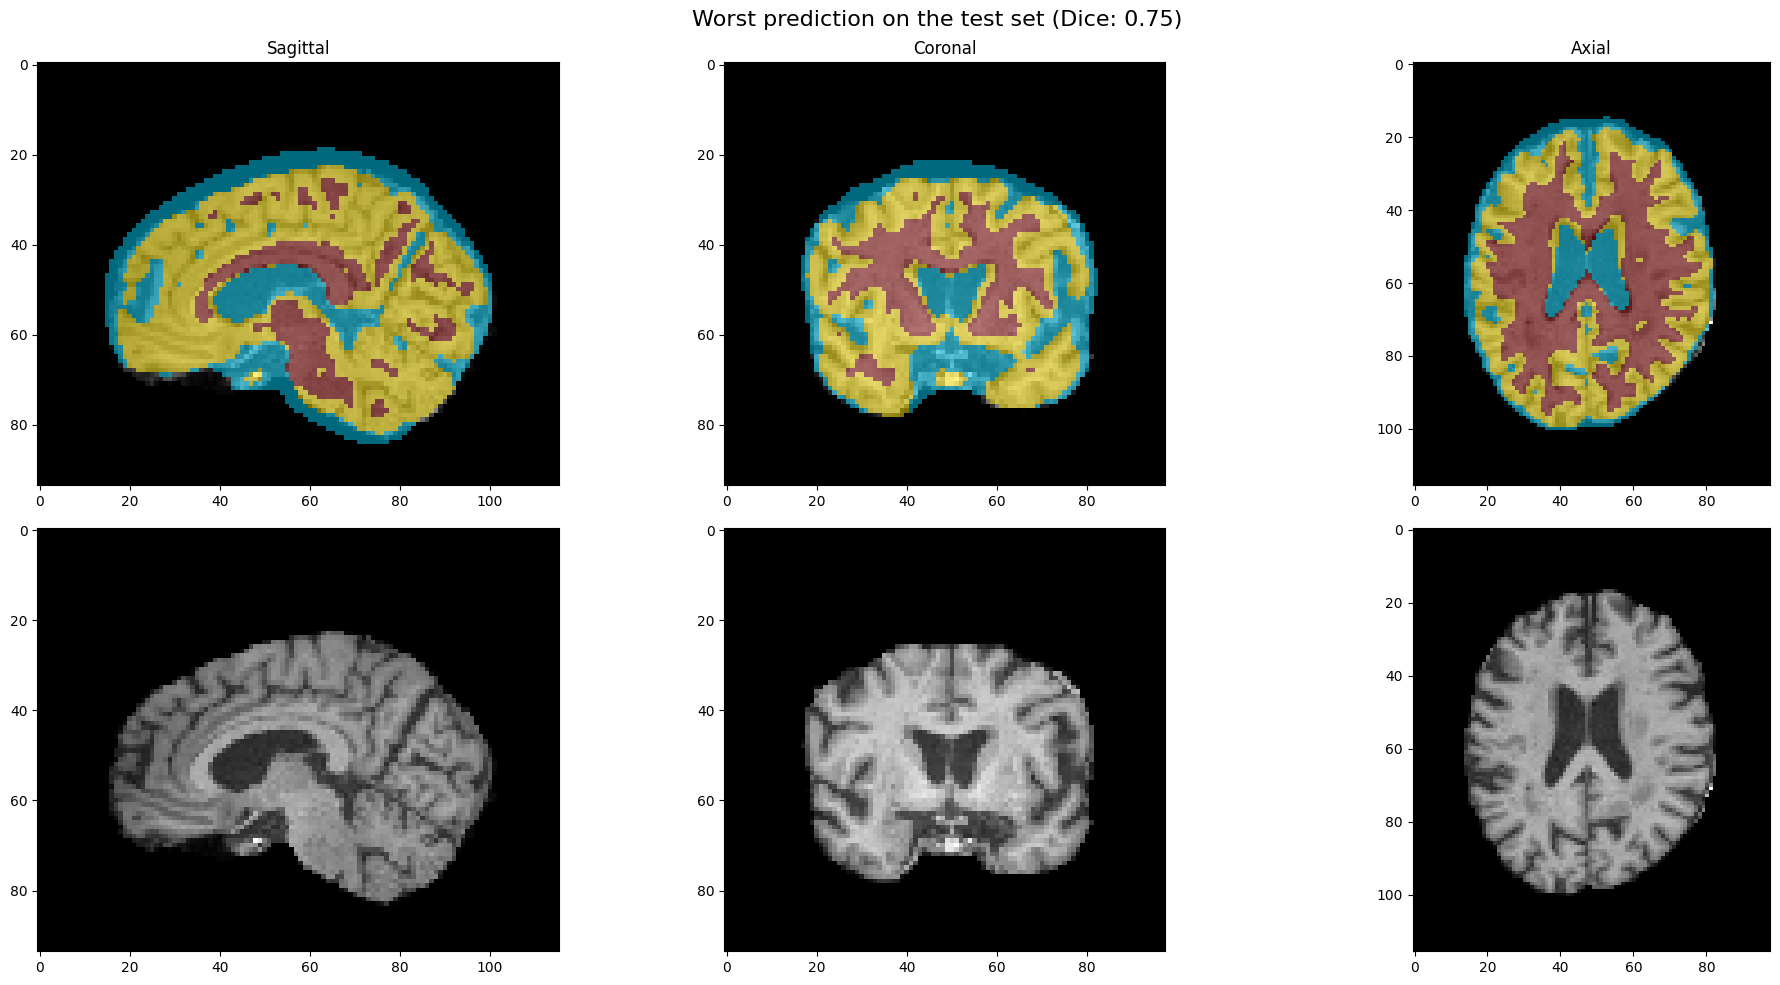

In [27]:
visualize_best_and_worst_samples(pred_seg_3)